#### LIBS

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import BackendSamplerV2
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram

##### Função de Teleport

In [18]:
def function_teleport(n=0,tomography='n'):
    # Registradores
    Alice = QuantumRegister(1, 'Alice')
    Bob = QuantumRegister(1, 'Bob')
    Secret = QuantumRegister(1, 'Secret')
    c = ClassicalRegister(3, 'c')  # apenas para medições de Alice e Secret

    if n > 0:
        ext = QuantumRegister(n, 'ext')
        circuit = QuantumCircuit(Secret, Alice, Bob, ext, c)
    else:
        circuit = QuantumCircuit(Secret, Alice, Bob, c)

    # EPR
    circuit.h(Alice)
    circuit.cx(Alice, Bob)
    circuit.barrier()

    # Swaps (linha)
    if n > 0:
        circuit.swap(Bob[0], ext[0])
        for i in range(1, n):
            circuit.swap(ext[i - 1], ext[i])
        final_target = ext[n - 1]
    else:
        final_target = Bob[0]

    # Estado secreto |+>
    circuit.barrier()
    circuit.h(Secret)
    circuit.barrier()

    # Medida de Bell
    circuit.cx(Secret, Alice)
    circuit.h(Secret)
    circuit.barrier()

    # Medições de Alice e Secret (registrador c tem 2 bits)
    circuit.measure(Alice, c[0])
    circuit.measure(Secret, c[1])
    circuit.barrier()

    # Correções condicionais
    with circuit.if_test((c[1], 1)):
        circuit.x(final_target)
    with circuit.if_test((c[0], 1)):
        circuit.z(final_target)

    circuit.barrier()
    if tomography == 'n':
        circuit.h(final_target)
        circuit.measure(Bob,c[2])
    else:
        pass

    return circuit

#### Construção do Circuito

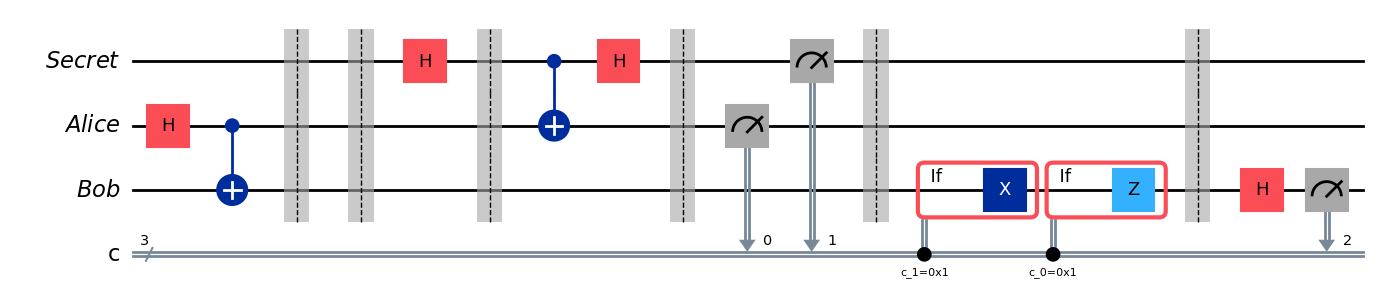

In [21]:
circuit_teleport_for_measure = function_teleport(n=0,tomography='n')
circuit_teleport_for_measure.draw('mpl')

##### Sem Ruído

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-13 16:25:20,595: Default instance not set. Searching all available instances.


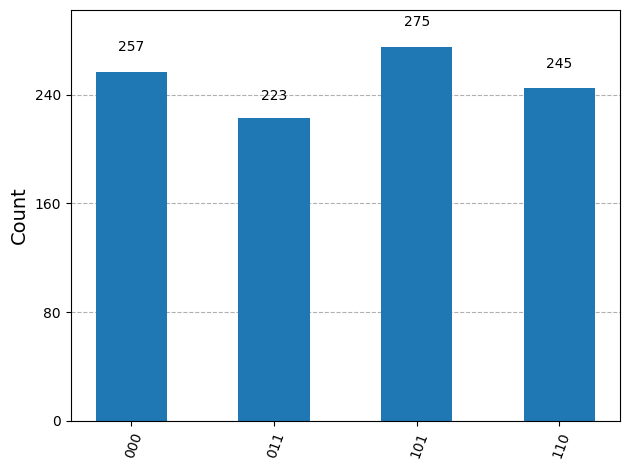

In [22]:
service = QiskitRuntimeService()
backend = AerSimulator()

tqc = transpile(circuit_teleport_for_measure, backend) #adapta o circuito para o backend (aqui, o simulador).
job = backend.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
counts = job.result().get_counts()  # obtém o resultado da execução.

plot_histogram(counts)

##### Com ruído

<IBMBackend('ibm_brisbane')>


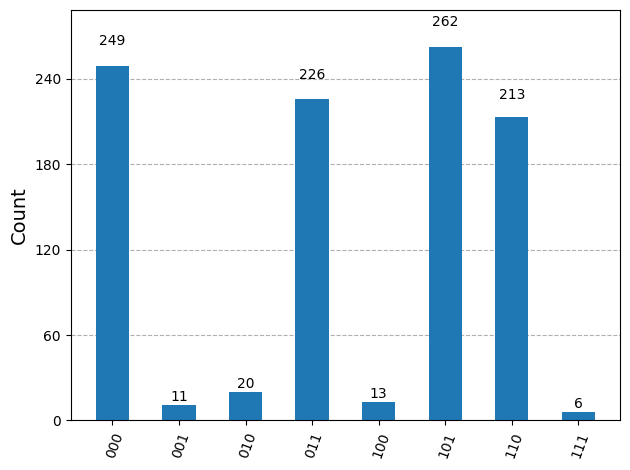

In [31]:
backend = service.least_busy(operational=True,
                             simulator=False,
                             min_num_qubits=127)
sampler = Sampler(mode = backend)
noise_model = NoiseModel.from_backend(backend)
backend_ruidoso = AerSimulator(noise_model=noise_model)
sampler = BackendSamplerV2(backend=backend_ruidoso)
print(backend)

tqc = transpile(circuit_teleport_for_measure, backend_ruidoso) #adapta o circuito para o backend (aqui, o simulador).
job = backend_ruidoso.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
counts = job.result().get_counts()  # obtém o resultado da execução.

plot_histogram(counts)

#### implementação de 1 a 20 swaps e realizando as medições

In [26]:
lista_circuitos = [
    {"nome": f"circuit_{j}_swaps", "circuito": function_teleport(n=j,tomography='n')}
    for j in range(1, 21)
]

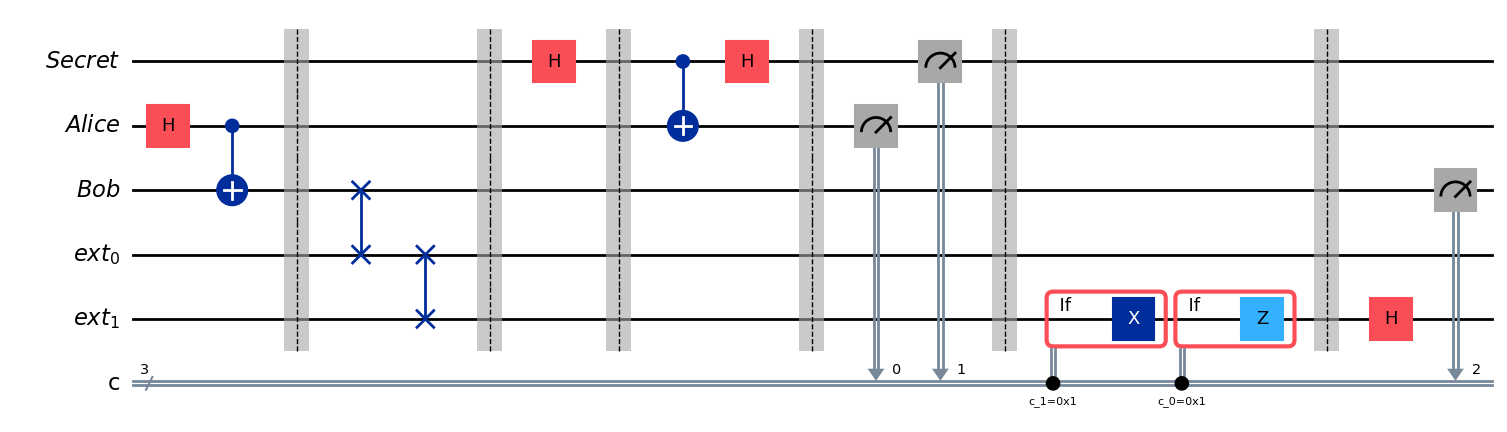

In [27]:

# Perguntar ao usuário qual circuito quer ver
escolha = input("Digite o número do circuito que deseja exibir (1 a 20): ")

# Validar a entrada
if escolha.isdigit():
    escolha = int(escolha)
    if 1 <= escolha <= len(lista_circuitos):
        display(lista_circuitos[escolha-1]["circuito"].draw('mpl'))  # Print no terminal
    else:
        print("Número fora do intervalo.")
else:
    print("Entrada inválida. Digite um número.")

Histograma para circuit_1_swaps:


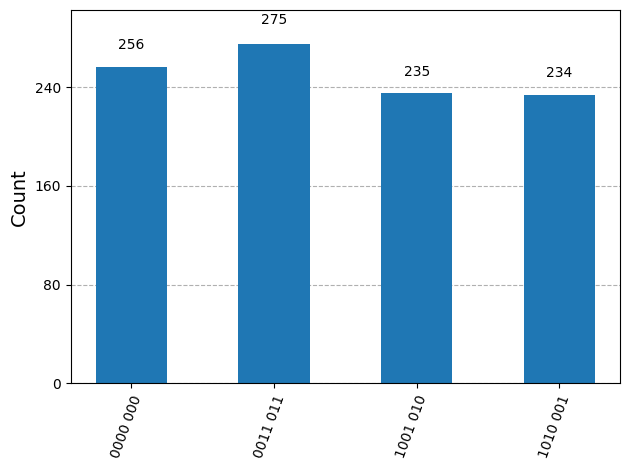

Histograma para circuit_2_swaps:


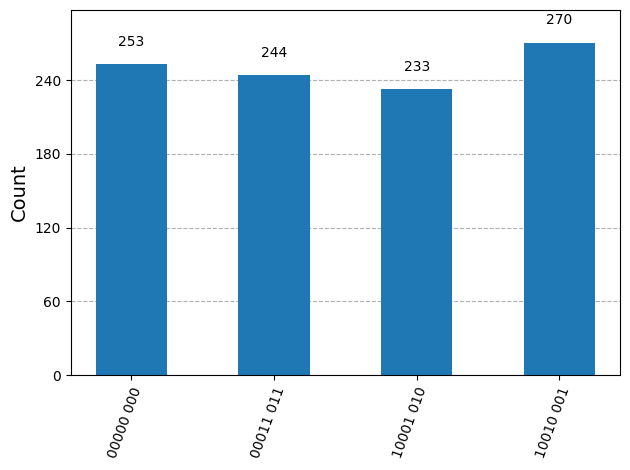

Histograma para circuit_3_swaps:


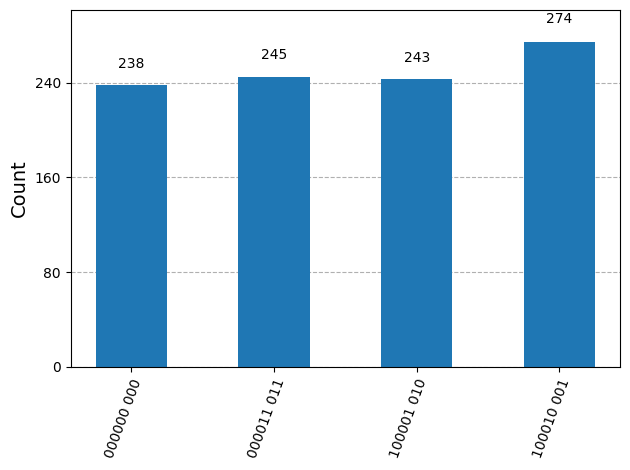

Histograma para circuit_4_swaps:


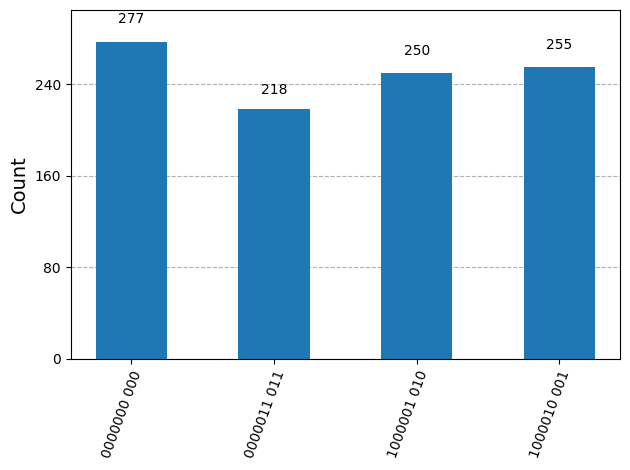

Histograma para circuit_5_swaps:


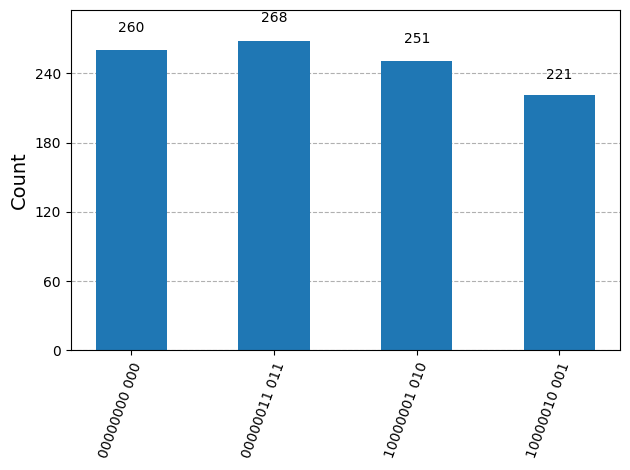

Histograma para circuit_6_swaps:


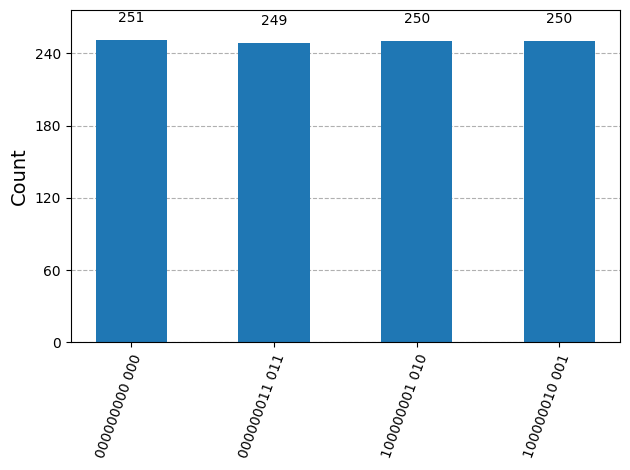

Histograma para circuit_7_swaps:


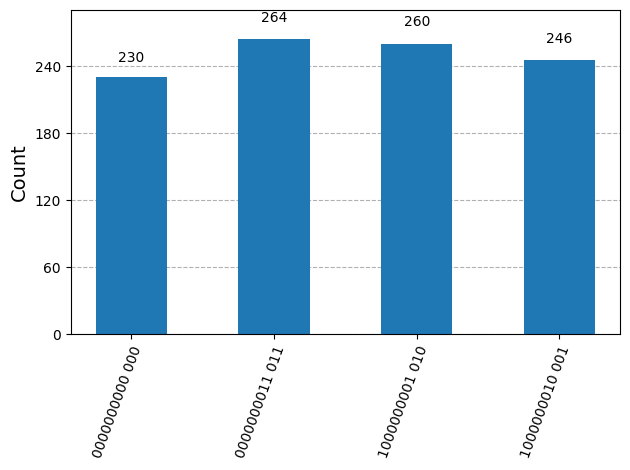

Histograma para circuit_8_swaps:


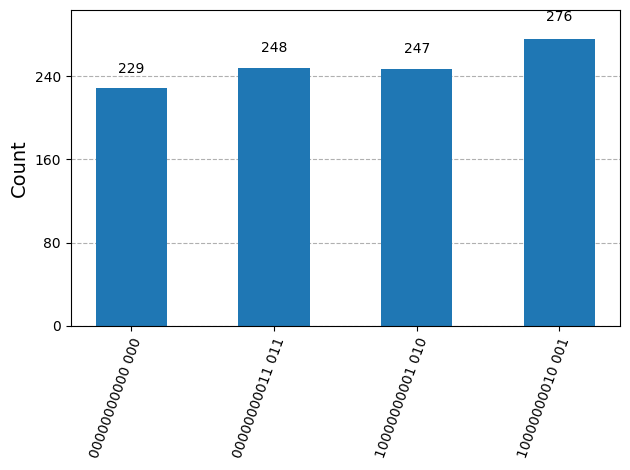

Histograma para circuit_9_swaps:


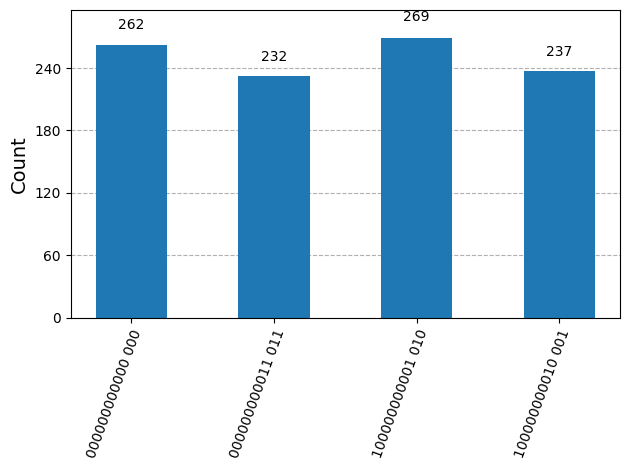

Histograma para circuit_10_swaps:


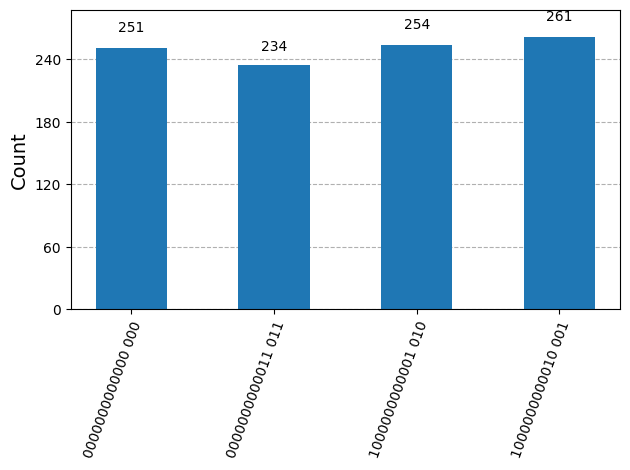

Histograma para circuit_11_swaps:


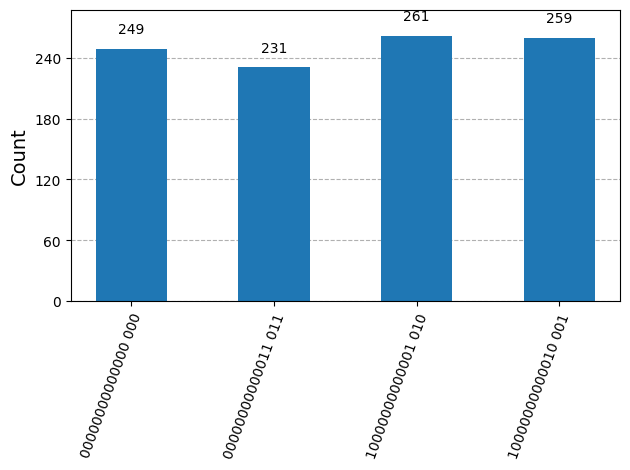

Histograma para circuit_12_swaps:


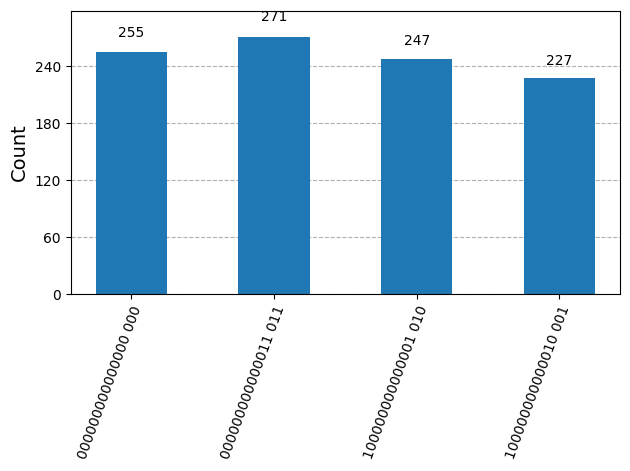

Histograma para circuit_13_swaps:


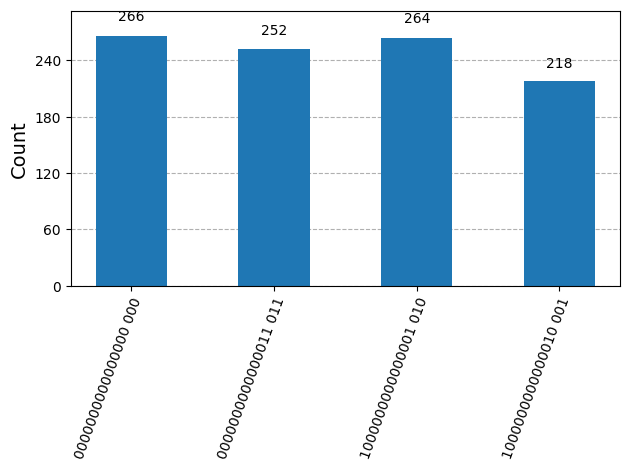

Histograma para circuit_14_swaps:


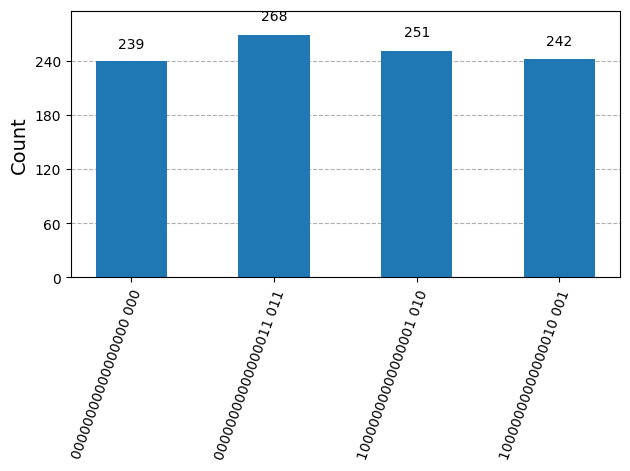

Histograma para circuit_15_swaps:


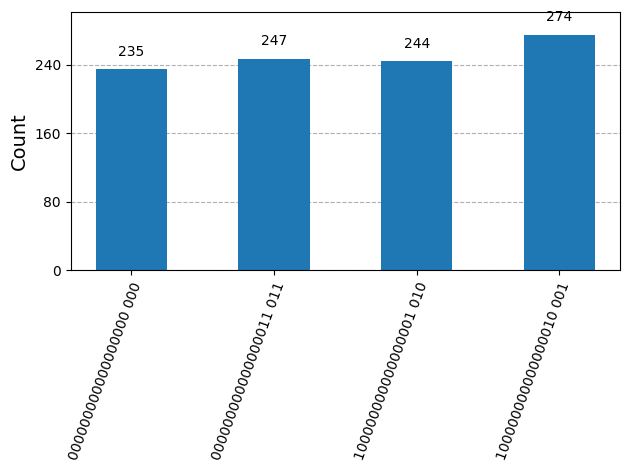

Histograma para circuit_16_swaps:


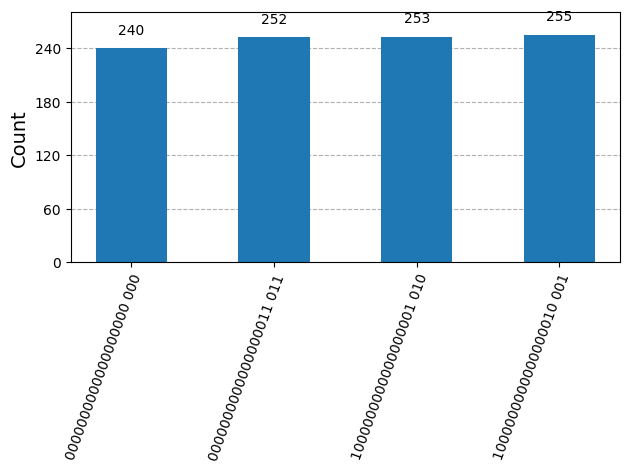

Histograma para circuit_17_swaps:


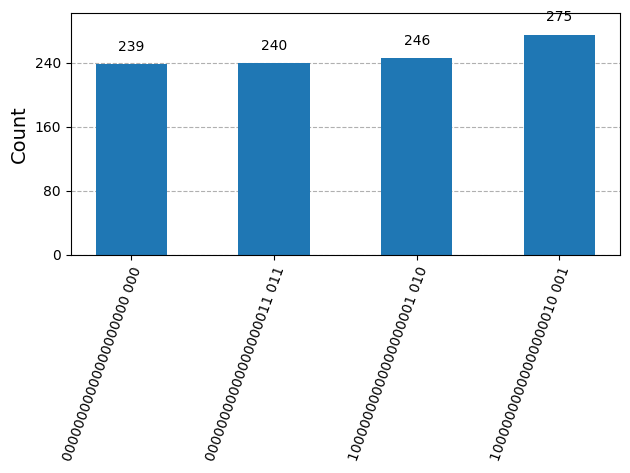

Histograma para circuit_18_swaps:


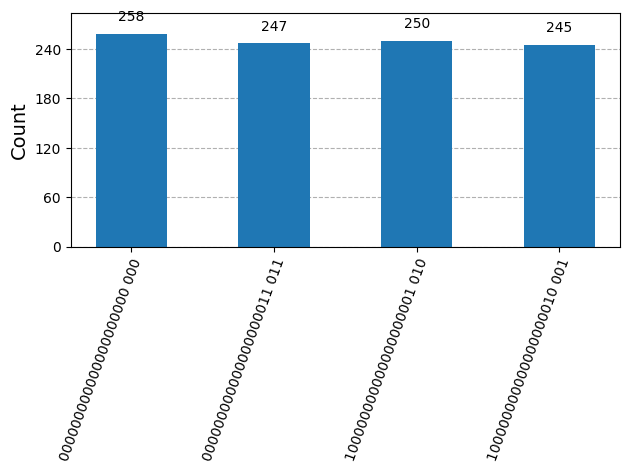

Histograma para circuit_19_swaps:


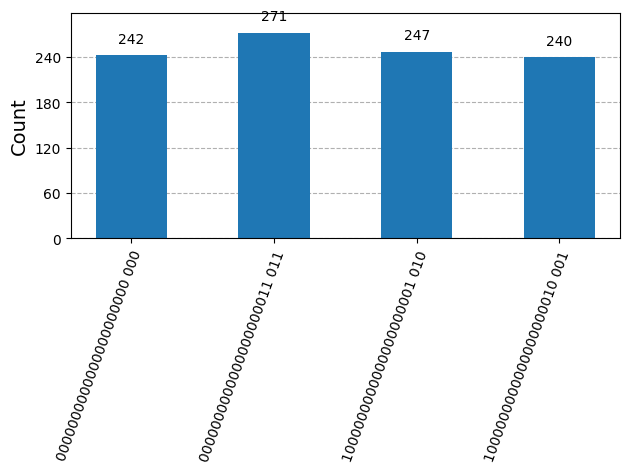

Histograma para circuit_20_swaps:


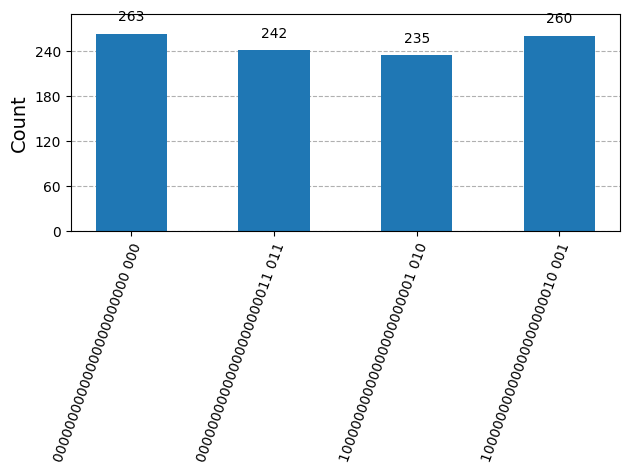

In [28]:
## Sem Ruído
for item in lista_circuitos:
    nome = item["nome"]
    circuito = item["circuito"]

    # Adiciona medições em todos os qubits
    circuito.measure_all()

    # Transpila para o backend
    tqc = transpile(circuito, backend)

    # Executa no simulador
    job = backend.run(tqc, shots=1000)
    counts = job.result().get_counts()

    # Exibe histograma
    print(f"Histograma para {nome}:")
    display(plot_histogram(counts))

Histograma para circuit_1_swaps:


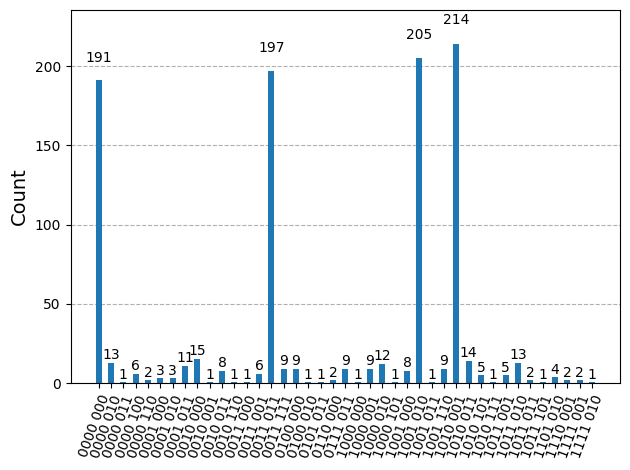

Histograma para circuit_2_swaps:


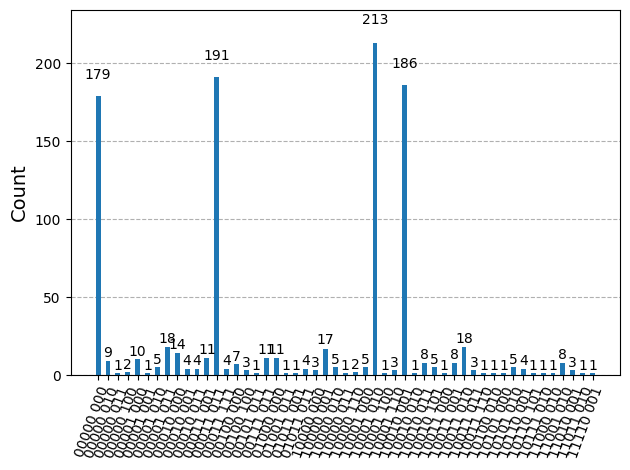

Histograma para circuit_3_swaps:


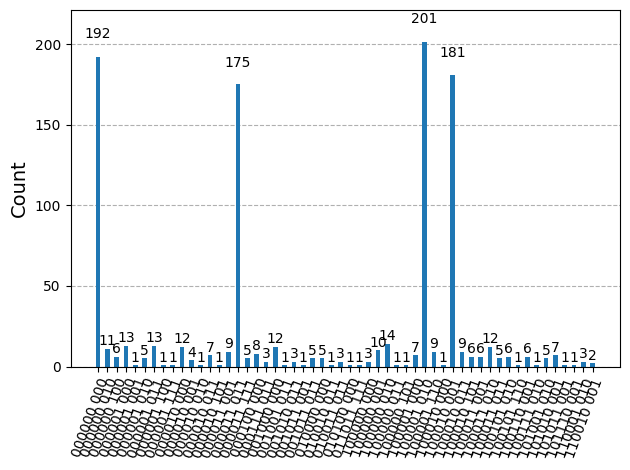

Histograma para circuit_4_swaps:


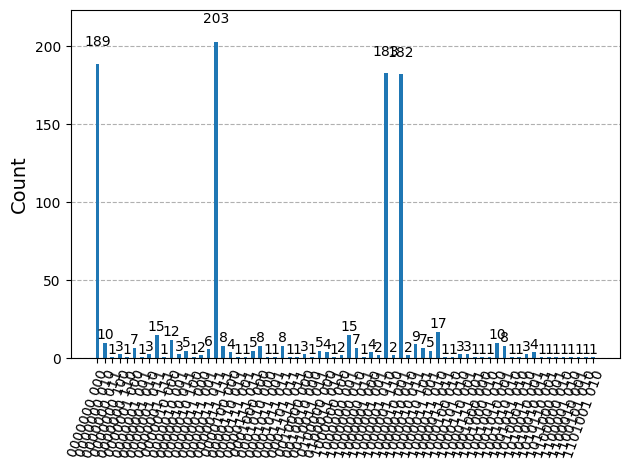

Histograma para circuit_5_swaps:


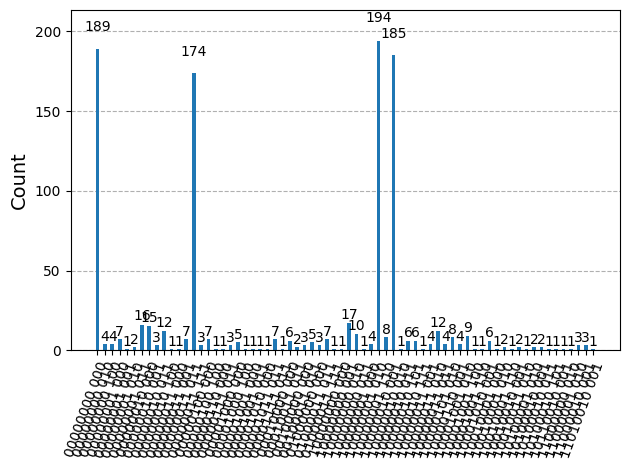

Histograma para circuit_6_swaps:


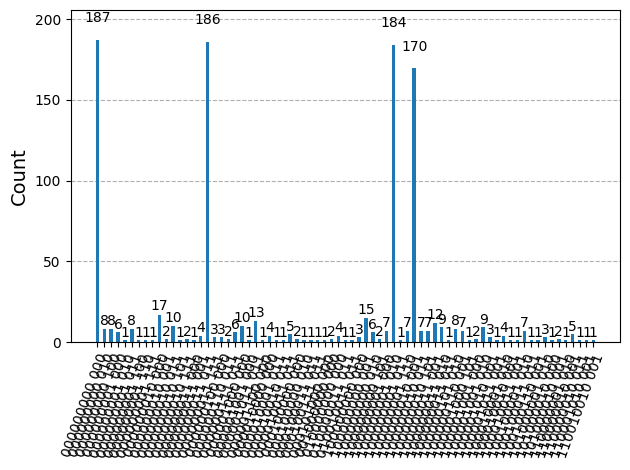

Histograma para circuit_7_swaps:


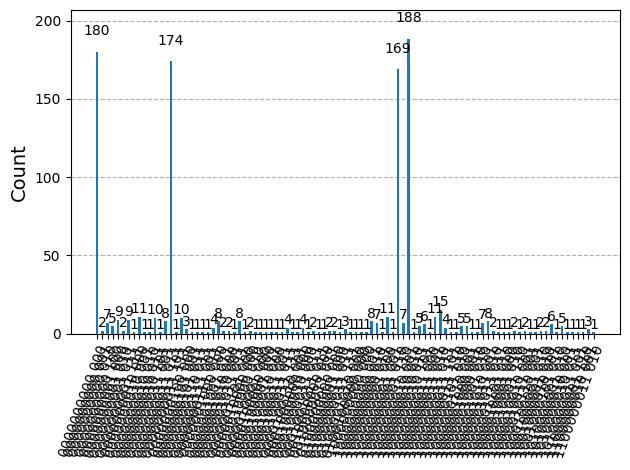

Histograma para circuit_8_swaps:


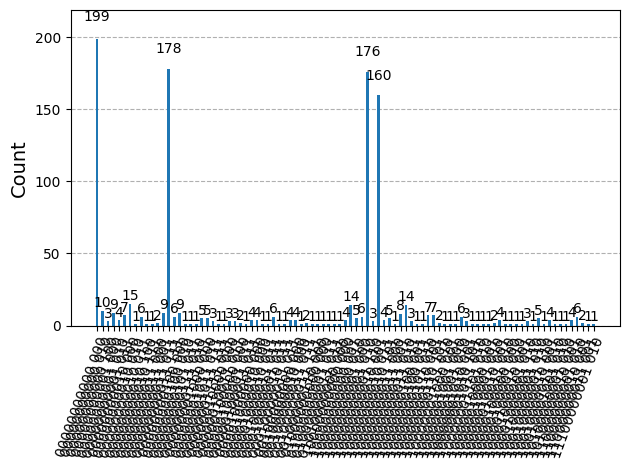

Histograma para circuit_9_swaps:


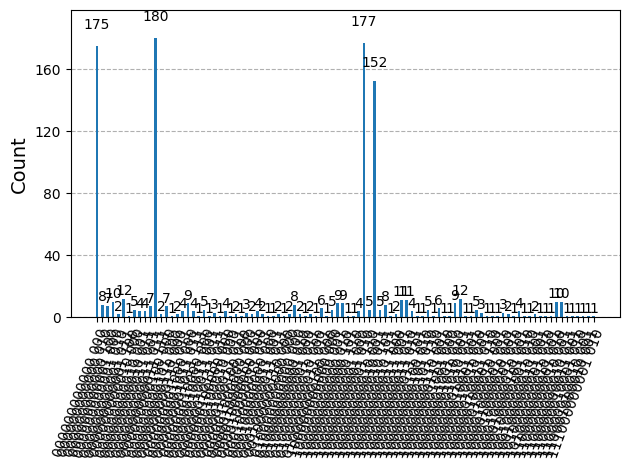

Histograma para circuit_10_swaps:


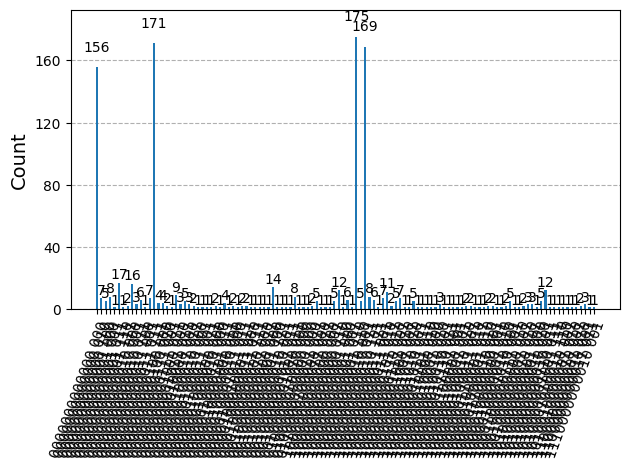

Histograma para circuit_11_swaps:


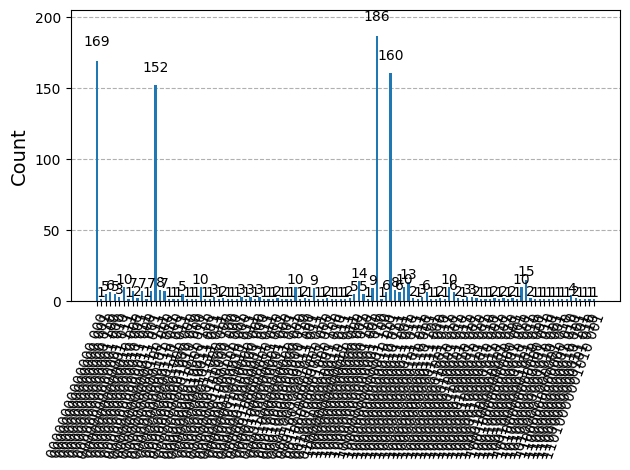

Histograma para circuit_12_swaps:


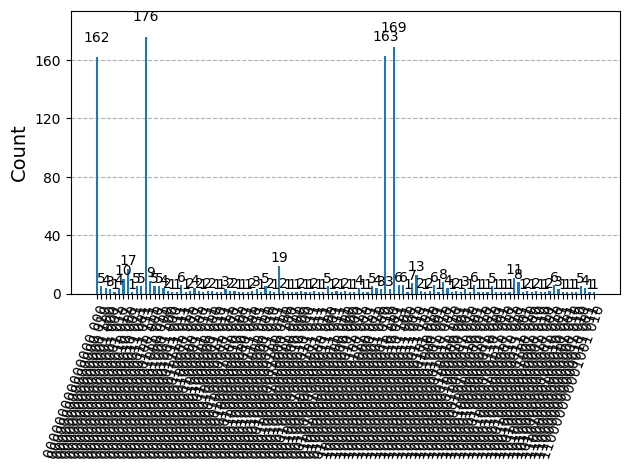

Histograma para circuit_13_swaps:


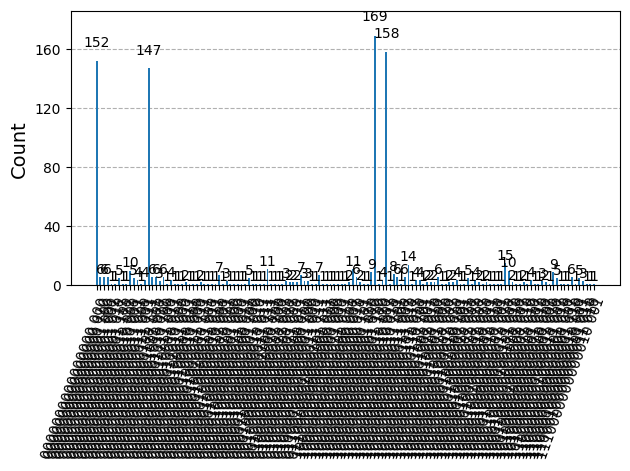

Histograma para circuit_14_swaps:


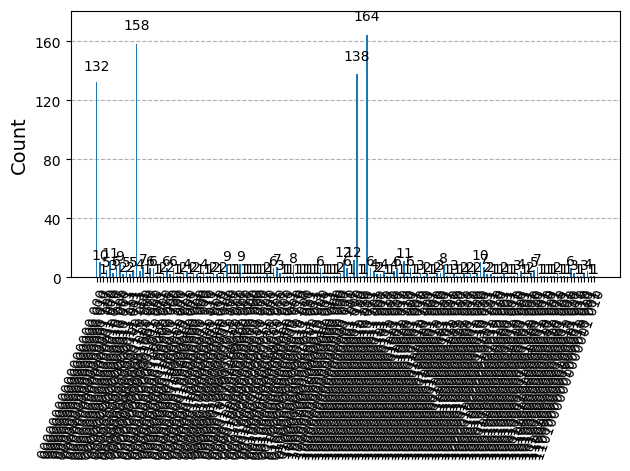

Histograma para circuit_15_swaps:


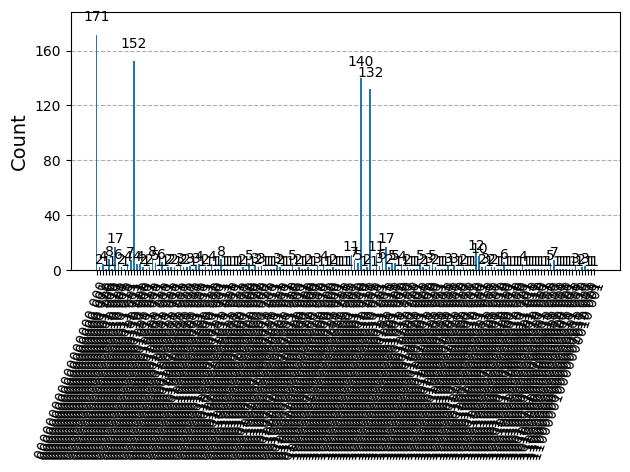

In [ ]:
## Com ruído
for item in lista_circuitos:
    nome = item["nome"]
    circuito = item["circuito"]

    # Transpila para o backend
    tqc = transpile(circuito, backend_ruidoso)

    # Executa no simulador
    job = backend_ruidoso.run(tqc, shots=1000)
    counts = job.result().get_counts()

    # Exibe histograma
    print(f"Histograma para {nome}:")
    display(plot_histogram(counts))

---

#### tomografia do teleport

In [11]:
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator

pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]

bases = {
    'I': pauli_list[0],
    'X': pauli_list[1],
    'Y': pauli_list[2],
    'Z': pauli_list[3],
}

def measurement_circuit(base,input_circuit, target):
    circuit = input_circuit.copy()

    if base == 'X':
        circuit.h(target)
    elif base == 'Y':
        circuit.sdg(target)
        circuit.h(target)

    creg = ClassicalRegister(1, 'c_tom')
    circuit.add_register(creg)
    circuit.measure(target,creg[0])

    return circuit

def tomography(my_circuit, target,shots):
    expectation_values = {}
    all_counts = {}

    for base in ['X','Y','Z']:
        circ       = measurement_circuit(base, my_circuit, target)
        transpiled = transpile(circ, backend)
        result     = backend.run(transpiled, shots=shots).result()
        counts     = result.get_counts()

        # Agora filtramos o primeiro bit da string (bits[0]), que corresponde a c_tom[0]
        p0 = sum(cnt for bits, cnt in counts.items() if bits[0]=='0')
        p1 = sum(cnt for bits, cnt in counts.items() if bits[0]=='1')
        total = p0 + p1 or 1

        expectation_values[base] = (p0 - p1) / total
        all_counts[base] = counts

    rho = 0.5 * (
        pauli_list[0]
        + expectation_values['X'] * pauli_list[1]
        + expectation_values['Y'] * pauli_list[2]
        + expectation_values['Z'] * pauli_list[3]
    )

    return rho, expectation_values



In [12]:
rho = tomography(circuit,target=2,shots=1000)
print(rho)

(array([[ 0.496+0.j   , -0.029+0.014j],
       [-0.029-0.014j,  0.504+0.j   ]]), {'X': -0.058, 'Y': -0.028, 'Z': -0.008})
